In [21]:
from tensorflow import keras
model = keras.models.load_model('article_model/article_vgg16.h5')

### Testing image with true label

In [23]:
# Import necessary libraries

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
from matplotlib.patches import Rectangle
from lxml import etree

# Enable Matplotlib backend for displaying static images
%matplotlib inline

In [25]:
# Subfolders for the class labels

import os

train_path = 'first_dataset_origin\images\images'
os.listdir(train_path)

# Annotations of the class labels
label_path = 'first_dataset_origin\label\label'
os.listdir(label_path)

# Read all the images and count the number of image paths in the training subfolders

image_path = glob.glob("first_dataset_origin\images\images\*\*.jpg")
len(image_path)

# Read all the annotation files and count the number of annotations in the training label folder

xmls_path = glob.glob("first_dataset_origin\label\label\*.xml")
len(xmls_path)

# Sort the annotation and image files in ascending order

xmls_path.sort(key = lambda x:x.split("\\")[-1].split(".xml")[0])
image_path.sort(key = lambda x:x.split("\\")[-1].split(".jpg")[0])

# Extract the annotation filename without file extension

xmls_train = [path.split("\\")[-1].split(".")[0] for path in xmls_path]
xmls_train[:5]

# Retrieve the image filename to match the annotation file counts
# Ensure unique counts of training images with the annotations

imgs_train = [img for img in image_path if (img.split("\\")[-1].split)(".jpg")[0] in xmls_train]
imgs_train[:5]

len(imgs_train),len(xmls_path)

# Extract label names as DataFrame column

labels = [label.split("\\")[-2] for label in imgs_train]
labels[:5]

labels = pd.DataFrame(labels, columns = ["Defect Type"])
labels

# One-hot encoding for multiple classes
from sklearn.preprocessing import LabelBinarizer

# Obtain training labels without duplication
Class = labels["Defect Type"].unique()
# Store data values in key:value pairs with Python dictionaries
Class_dict = dict(zip(Class, range(1,len(Class) + 1)))
labels["Class"] = labels["Defect Type"].apply(lambda x: Class_dict[x])

lb = LabelBinarizer()
# Fit label binarizer
lb.fit(list(Class_dict.values()))
# Convert multi-class labels to binary labels (belong or does not belong to the class)
transformed_labels = lb.transform(labels["Class"])
y_bin_labels = []  

for i in range(transformed_labels.shape[1]):
    y_bin_labels.append("Class" + str(i))
    labels["Class" + str(i + 1)] = transformed_labels[:, i]



In [26]:
labels.drop("Class", axis = 1, inplace = True)
labels.drop("Defect Type", axis = 1, inplace = True)
labels.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [27]:
# Function to parse and extract information from annotation files

def to_labels(path):
    # Read the annotation file
    xml = open("{}".format(path)).read()                         
    sel = etree.HTML(xml)
    # Obtain the image width
    width = int(sel.xpath("//size/width/text()")[0])
    # Obtain the image height
    height = int(sel.xpath("//size/height/text()")[0])  
    # Extract the bounding box coordinates
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    # Return the relative coordinates
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [28]:
# Display the relative bounding box coordinates

coors = [to_labels(path) for path in xmls_path]
coors[:5]

# Set four coordinate points as outputs

xmin, ymin, xmax, ymax = list(zip(*coors))

# Convert to Numpy array
xmin = np.array(xmin)
ymin = np.array(ymin)
xmax = np.array(xmax)
ymax = np.array(ymax)
label = np.array(labels.values)

# Creates a Dataset whose elements are slices of the given tensors
# Slicing a 1D tensor produces scalar tensor elements

labels_dataset = tf.data.Dataset.from_tensor_slices((xmin, ymin, xmax, ymax, label))
labels_dataset




<TensorSliceDataset shapes: ((), (), (), (), (10,)), types: (tf.float64, tf.float64, tf.float64, tf.float64, tf.int32)>

In [29]:
# Load the image from image path

def load_image(path):
    image = tf.io.read_file(path)                           
    image = tf.image.decode_jpeg(image,3)               
    image = tf.image.resize(image,[224,224])               
    image = tf.cast(image,tf.float32)  
    image = image / 255
    return image

In [30]:
# Build the dataset

dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
dataset = dataset.map(load_image)

dataset_label = tf.data.Dataset.zip((dataset, labels_dataset))
dataset_label

# Shuffle the images and extract the images by the defined batch size

batch_size = 32
dataset_label = dataset_label.repeat().shuffle(500).batch(batch_size)

# Creates a Dataset that prefetches elements from this dataset
# Most dataset input pipelines should end with a call to prefetch
# This allows later elements to be prepared while the current element is being processed
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements

dataset_label = dataset_label.prefetch(tf.data.experimental.AUTOTUNE)



In [31]:
# Split the dataset into 77.5% for training and 17.5% for validating and 5% untouch for testing


train_count = int(len(imgs_train) * 0.775)
test_count = int(len(imgs_train) * 0.175)
untouch_count = int(len(imgs_train)*0.05)
train_count, test_count, untouch_count

(1767, 399, 114)

In [32]:
train_dataset = dataset_label.skip(untouch_count)
untouch_dataset = dataset_label.take(untouch_count)

train_dataset = train_dataset.skip(test_count)
test_dataset = train_dataset.take(test_count)


In [33]:
class_dict = {v:k for k,v in Class_dict.items()}
class_dict

{1: 'crescent_gap',
 2: 'crease',
 3: 'silk_spot',
 4: 'water_spot',
 5: 'welding_line',
 6: 'inclusion',
 7: 'oil_spot',
 8: 'waist_folding',
 9: 'rolled_pit',
 10: 'punching_hole'}

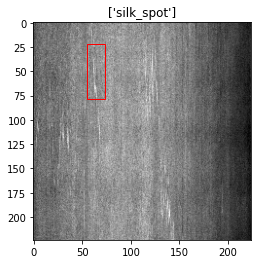

In [34]:
# Display a sample training image with its label

for img, label in train_dataset.take(1):
    plt.imshow(keras.preprocessing.image.array_to_img(img[0]))     
    out1, out2, out3, out4, out5 = label                            
    xmin, ymin, xmax, ymax = out1[0].numpy()*224, out2[0].numpy()*224, out3[0].numpy()*224, out4[0].numpy()*224
    rect = Rectangle((xmin,ymin),(xmax - xmin),(ymax - ymin), fill = False, color = "r")  
    ax = plt.gca()                      
    ax.axes.add_patch(rect)   
    pred_imglist = []
    pred_imglist.append(class_dict[np.argmax(out5[0])+1])
    plt.title(pred_imglist)
    plt.show()

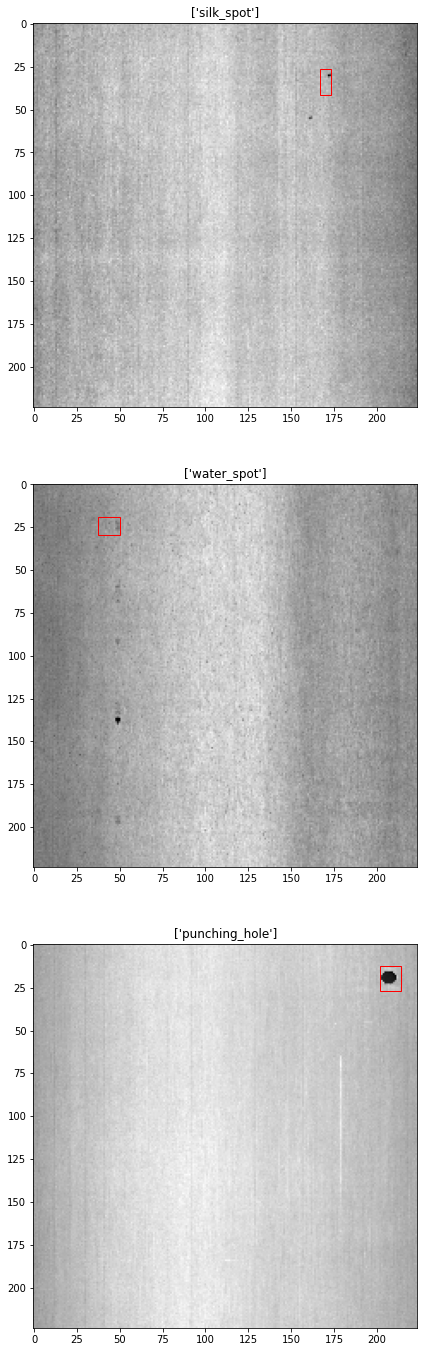

In [35]:
plt.figure(figsize = (10, 24))
for img, _ in test_dataset.take(1):
    out1, out2, out3, out4, label = model.predict(img)
    for i in range(3):
        plt.subplot(3, 1, i + 1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))    
        pred_imglist = []
        pred_imglist.append(class_dict[np.argmax(out5[i]) + 1])
        plt.title(pred_imglist)
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 
        ax = plt.gca()                   
        ax.axes.add_patch(rect)

### Check with untouch_dataset

In [36]:
# Append all the true labels into a list

true_labels = []

for _, label in untouch_dataset:    
    out1, out2, out3, out4, out5 = label                              
    true_labels.append(class_dict[np.argmax(out5) + 1])

In [77]:
true_labels

['silk_spot',
 'silk_spot',
 'welding_line',
 'crescent_gap',
 'water_spot',
 'waist_folding',
 'water_spot',
 'water_spot',
 'silk_spot',
 'silk_spot',
 'welding_line',
 'water_spot',
 'silk_spot',
 'punching_hole',
 'punching_hole',
 'oil_spot',
 'water_spot',
 'water_spot',
 'water_spot',
 'water_spot',
 'punching_hole',
 'punching_hole',
 'punching_hole',
 'crescent_gap',
 'water_spot',
 'silk_spot',
 'silk_spot',
 'silk_spot',
 'crescent_gap',
 'punching_hole',
 'crescent_gap',
 'waist_folding',
 'silk_spot',
 'crescent_gap',
 'inclusion',
 'oil_spot',
 'silk_spot',
 'crescent_gap',
 'inclusion',
 'punching_hole',
 'water_spot',
 'welding_line',
 'inclusion',
 'oil_spot',
 'inclusion',
 'welding_line',
 'punching_hole',
 'silk_spot',
 'waist_folding',
 'rolled_pit',
 'silk_spot',
 'waist_folding',
 'oil_spot',
 'inclusion',
 'oil_spot',
 'silk_spot',
 'crescent_gap',
 'oil_spot',
 'oil_spot',
 'silk_spot',
 'punching_hole',
 'silk_spot',
 'water_spot',
 'silk_spot',
 'welding_line

In [92]:
label[4]

<tf.Tensor: shape=(32, 10), dtype=int32, numpy=
array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0,

In [96]:
untouch_prediction = []
untouch_label = []
for img, label in untouch_dataset:
    # out1, out2, out3, out4, out5 = label

    predictions = model.predict(img)
    untouch_prediction.extend(np.argmax(predictions[4], axis = 1))
    
    untouch_label.extend(np.argmax(label[4], axis = 1))


In [127]:
class_dict(untouch_label)

TypeError: 'dict' object is not callable

In [38]:
target_names = ['cresent_gap', 'crease', 'silk_spot', 'water_spot', 'welding_line', 
                'inclusion', 'oil_spot', 'waist_folding', 'rolled_pit', 'punching_hole']

In [124]:
# untouch_prediction
to_labels

[5,
 3,
 5,
 2,
 6,
 2,
 2,
 4,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 3,
 8,
 2,
 3,
 2,
 0,
 4,
 2,
 6,
 5,
 6,
 4,
 3,
 9,
 2,
 4,
 0,
 9,
 3,
 1,
 3,
 2,
 3,
 4,
 9,
 6,
 2,
 2,
 2,
 2,
 3,
 5,
 4,
 2,
 1,
 3,
 6,
 3,
 3,
 2,
 5,
 3,
 2,
 1,
 4,
 3,
 2,
 2,
 2,
 9,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 4,
 2,
 2,
 0,
 9,
 2,
 2,
 3,
 3,
 4,
 2,
 3,
 0,
 9,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 4,
 0,
 9,
 0,
 6,
 2,
 2,
 4,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 3,
 3,
 2,
 3,
 0,
 3,
 6,
 2,
 4,
 0,
 3,
 6,
 2,
 1,
 2,
 0,
 3,
 0,
 2,
 2,
 2,
 2,
 2,
 4,
 3,
 3,
 3,
 3,
 2,
 4,
 2,
 0,
 2,
 3,
 2,
 3,
 3,
 2,
 8,
 3,
 6,
 4,
 5,
 2,
 2,
 0,
 3,
 2,
 0,
 2,
 4,
 2,
 6,
 3,
 4,
 3,
 4,
 2,
 4,
 2,
 3,
 2,
 3,
 5,
 3,
 3,
 3,
 3,
 3,
 2,
 0,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 4,
 2,
 3,
 2,
 2,
 2,
 4,
 2,
 6,
 3,
 3,
 5,
 3,
 2,
 3,
 2,
 4,
 4,
 0,
 2,
 4,
 4,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 4,
 3,
 3,
 3,
 3,
 8,
 3,
 4,
 7,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 3,
 0,
 2,
 2,
 2,
 2,
 2,
 6,


In [122]:
confusion_matrix(untouch_label, untouch_prediction, labels = target_names)

ValueError: At least one label specified must be in y_true

In [40]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, test_labels, labels = target_names)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 7, 4, 2, 3, 2, 1, 1, 4],
       [0, 0, 7, 3, 3, 2, 1, 1, 1, 0],
       [0, 0, 3, 1, 0, 1, 0, 0, 0, 3],
       [0, 0, 3, 1, 0, 1, 1, 2, 0, 0],
       [0, 0, 3, 2, 2, 0, 3, 2, 0, 1],
       [0, 0, 2, 0, 1, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 3, 3, 1, 2, 1, 1, 0, 1]], dtype=int64)

In [43]:
for img_1, label_1 in untouch_dataset.take(1):
    print(img_1)
    print(label_1)

tf.Tensor(
[[[[0.0517507  0.0517507  0.0517507 ]
   [0.05385154 0.05385154 0.05385154]
   [0.05385154 0.05385154 0.05385154]
   ...
   [0.314146   0.314146   0.314146  ]
   [0.32603648 0.32603648 0.32603648]
   [0.3254902  0.3254902  0.3254902 ]]

  [[0.05805322 0.05805322 0.05805322]
   [0.05480693 0.05480693 0.05480693]
   [0.05980392 0.05980392 0.05980392]
   ...
   [0.3319331  0.3319331  0.3319331 ]
   [0.32878762 0.32878762 0.32878762]
   [0.32410422 0.32410422 0.32410422]]

  [[0.057493   0.057493   0.057493  ]
   [0.05693778 0.05693778 0.05693778]
   [0.06022409 0.06022409 0.06022409]
   ...
   [0.33752057 0.33752057 0.33752057]
   [0.3393465  0.3393465  0.3393465 ]
   [0.3394517  0.3394517  0.3394517 ]]

  ...

  [[0.0155012  0.0155012  0.0155012 ]
   [0.0187675  0.0187675  0.0187675 ]
   [0.0205332  0.0205332  0.0205332 ]
   ...
   [0.27703163 0.27703163 0.27703163]
   [0.28828585 0.28828585 0.28828585]
   [0.28433248 0.28433248 0.28433248]]

  [[0.01568628 0.01568628 0.015686

### Check new prediction

In [111]:
img_path = 'first_dataset_origin\images\images\\rolled_pit\img_06_4404580000_00741.jpg'
img_test = load_image(img_path)
img_test = tf.expand_dims(img_test, axis = 0)

In [112]:
out1, out2, out3, out4, label = model.predict(img_test)  

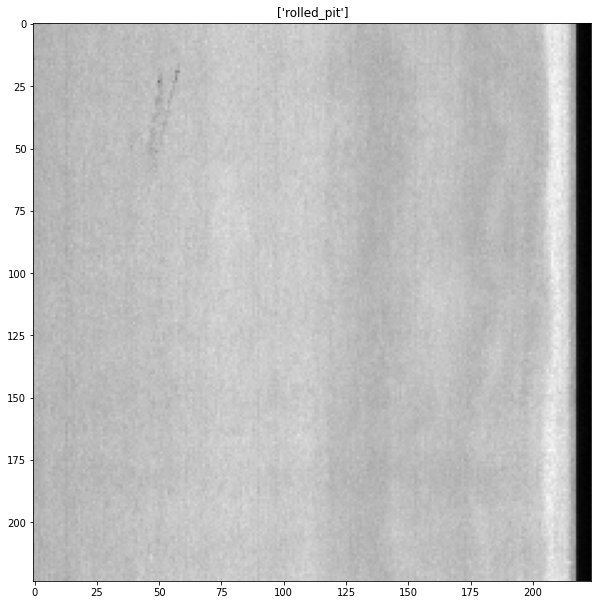

In [117]:
plt.figure(figsize = (10, 24))
out1, out2, out3, out4, label = model.predict(img_test)       
plt.imshow(keras.preprocessing.image.array_to_img(img_test))    
pred_imglist = []
pred_imglist.append(class_dict[np.argmax(label) + 1])
plt.title(pred_imglist)
xmin, ymin, xmax, ymax = out1[0]*224, out2[0]*224, out3[0]*224, out4[0]*224
rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 
ax.axes.add_patch(rect)   
pred_imglist = []
pred_imglist.append(class_dict[np.argmax(label)+1])
plt.title(pred_imglist)
plt.show()               

In [87]:
result = model.evaluate(test_dataset)

399/399 [==============================] - 1865s 5s/step - loss: 0.0030 - xmin_loss: 4.5823e-04 - ymin_loss: 9.7669e-04 - xmax_loss: 4.4291e-04 - ymax_loss: 0.0011 - class_loss: 2.1188e-05 - xmin_mae: 0.0124 - xmin_acc: 0.0000e+00 - ymin_mae: 0.0172 - ymin_acc: 0.0000e+00 - xmax_mae: 0.0123 - xmax_acc: 0.0907 - ymax_mae: 0.0182 - ymax_acc: 0.0749 - class_mae: 4.2365e-06 - class_acc: 1.0000


In [ ]:
114/114 [==============================] - 573s 4s/step - 
loss: 0.0025 - xmin_loss: 3.0209e-04 - ymin_loss: 8.7229e-04 -
 xmax_loss: 2.7851e-04 - ymax_loss: 9.5842e-04 - 
 class_loss: 4.9657e-05 - xmin_mae: 0.0113 - 
 xmin_acc: 0.0000e+00 - ymin_mae: 0.0165 - 
 ymin_acc: 0.0000e+00 - xmax_mae: 0.0110 - 
 xmax_acc: 0.0943 - ymax_mae: 0.0159 - 
 ymax_acc: 0.0795 - class_mae: 9.9208e-06 - 
 class_acc: 1.0000
